# Image Classification using EmuCore
#### Device: EmuCore

## Introduction

The classification of objects based on visual information is something which almost all of us, as humans, do every day without thinking about it. Here by classification, we mean simply telling what kind of object or symbol is in an image. However, getting machines to reliably and efficiently recognize what is in an image has proven to be a major challenge, although great progress has been made recently. The challenge of solving what, to us humans, is an "easy" problem using machines is typified in [this xkcd comic](https://xkcd.com/1425/) for example (although keep in mind this is an older comic and image recognition has progressed a lot since it was made). A simple task, which humans learn early in life is to read handwritten text. Given the relative ease of generating handwritten digits (getting someone to write them) and the relative simplicity of the task (can be done with greyscale images, does not require high resolution, plain white background), it provides a natural setting for demonstrating image classification capabilities. This task is so well suited for benchmarking and examples, that the [National Institute of Standards and Technology](https://www.nist.gov) has released a [dataset of handwritten digits](https://www.nist.gov/itl/products-and-services/emnist-dataset) for these purposes, we use a subset of these data known as [MNIST](https://yann.lecun.com/exdb/mnist/) in this example using the [QCi EmuCore system](https://quantumcomputinginc.com/learn/developer-resources/reservoir-computing/emucore-direct-software-package/v1.0.6/getting-started), which emulates the action of an optimcal reservoir.

## Importance


One of the most successful approaches to date for image classification is [deep learning, specifically techniques based on convolutional neural networks](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-021-00444-8). These techniques have the advantage over many other machine learning techniques tha they do not require as much human intervention, for example in pre-processing the data, or choosing a feature set to search over. However the disadvantage of these techniques is that the networks are difficult and computationally expensive to train, in fact training one model can [release as much carbon as five cars over their lifetime](https://www.technologyreview.com/2019/06/06/239031/training-a-single-ai-model-can-emit-as-much-carbon-as-five-cars-in-their-lifetimes/) and require substantial expertise to train. This is where the reservoir approach comes in, because of the way they are trained, a reserviour computing solution can be implemented with substantially less effort or expertise, and therefore provides a promising direction for more economical image recognition than traditional networks. Details of this approach and its advantage over other neural network approaches can be found in [this lessson](https://quantumcomputinginc.com/learn/lessons/neural-networks-and-reservoir-computing).

## Applications

Image classification has a number of applications, digit recognition as applied in this example could be useful to essentially allow a computer to "read" handwritten text (assuming a separate routine could reliably isolate the digits). There are a number of others however, for example, image regonition could be used to [automatically detect diseases](https://ieeexplore.ieee.org/document/8241753) for example by being trained to find signs of disease in an MRI image. Self driving cars also often [heavily rely on computer vision](https://arxiv.org/pdf/2311.09093). Another, perhaps less obvious, application is [Earth observation](https://arxiv.org/pdf/2305.08413), the use of satelite images to monitor changes in the world. Earth observation specifically has the challenge that some of the machine learning would ideally be deployed in space with severe limitations on things like power availablity, presenting a potential opportunity for unconventional models. More broadly, image classification is the first step toward developing [computer vision](https://www.ibm.com/topics/computer-vision), automated systems which are able to interpret and process images similar to a way a human would. A recent study found that [cost is a major barrier for integrating AI into many vision based tasks](https://futuretech-site.s3.us-east-2.amazonaws.com/2024-01-18+Beyond_AI_Exposure.pdf), showing a key opportunity for novel approaches like reservior computing. The impacts of computer vision are already being felt, it is projected that the market size for computer vision [will reach $25 billion in 2024](https://www.statista.com/outlook/tmo/artificial-intelligence/computer-vision/worldwide).



## Methodology

In what follows, we present an image classification model built using using QCi's EmuCore technology. 

The dataset consists of 70,000 images of handwritten digits 0-9; 60,000 samples are used for training and the remaining 10,000 images are kept for testing. Each sample is a 28 x 28 pixel image.

The images are serialized in one of the two spatial directions and sent through EmuCore. The output is an enriched dataset which is then used to train a simple linear model.

## Get train and test datasets

We use the **mnist** package from __tensorflow__ to import training data. 

In [32]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape: (60000, 28, 28)
x_test shape: (10000, 28, 28)
y_train shape: (60000,)
y_test shape: (10000,)


### Plot some of the samples

We plot the first few images in training data,

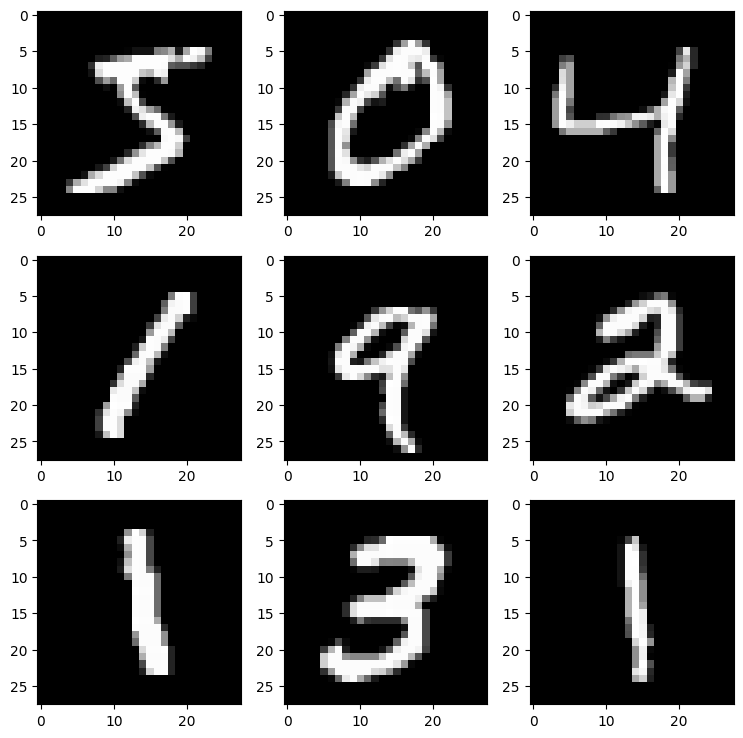

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize = (9,9))

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap("gray"))

plt.show()

And in the testing data,

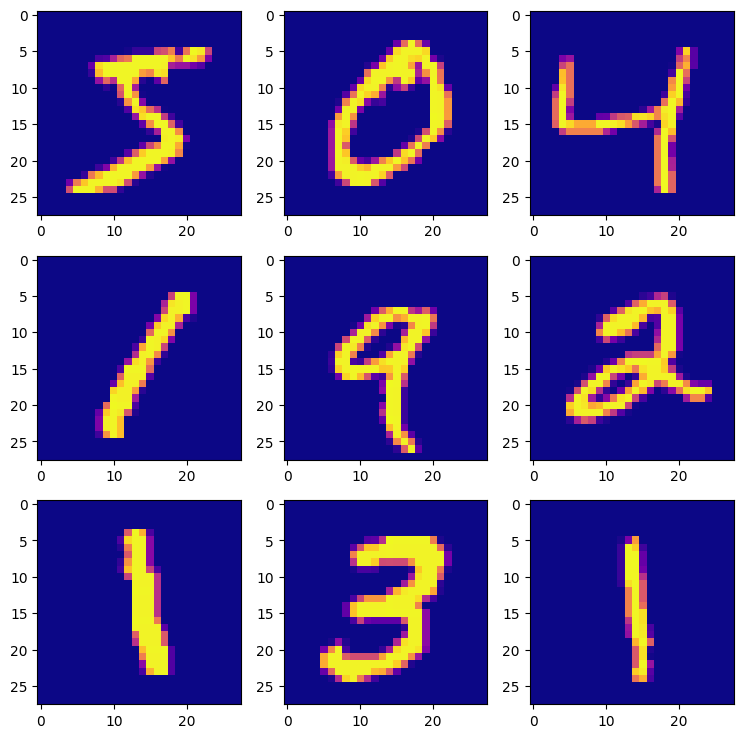

In [34]:
plt.figure(figsize = (9,9))

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap("plasma"))
    
plt.show()

### Normalize data

As each image is 28 by 28 pixels, each sample in the data consists of a 28 by 28 matrix. The elements of the matrix are integers between 0 and 255, each representing one of the 256 colors. We can normalize values to a 0-1 range. This normalization improves the behavior of the reservoir.

In [35]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0

### Flatten data

We should now **flatten** in one of the two spatial directions. We have tested with both directions and the results are nearly identical.

In [36]:
#x_train = np.swapaxes(x_train, 1, 2)
#x_test = np.swapaxes(x_test, 1, 2)

x_train_flat = x_train.reshape((x_train.shape[0], 28 * 28))
x_test_flat = x_test.reshape((x_test.shape[0], 28 * 28))

print("Flat x_train shape:", x_train_flat.shape)
print("Flat x_test shape:", x_test_flat.shape)

Flat x_train shape: (60000, 784)
Flat x_test shape: (10000, 784)


We can plot the first few flattened samples,

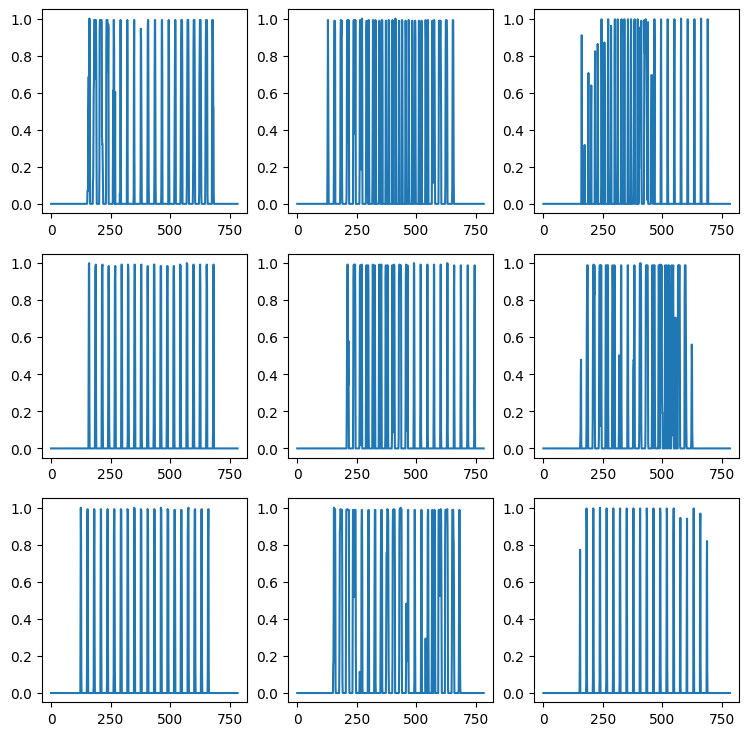

In [37]:
plt.figure(figsize = (9,9))

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.plot(x_train_flat[i].reshape(784,1))
    
plt.show()

## Run the dataset through EmuCore

We now push the flattened training and testing data through the reservoir.

In [42]:
from emucore_direct.client import EmuCoreClient

IP_ADDR = "172.22.19.49" 
VBIAS = 0.31
GAIN = 0.72
NUM_NODES = 2500
NUM_TAPS = 2500
FEATURE_SCALING = 0.1
DENSITY = 1.0

# Instantiate an EmuCore instance
client = EmuCoreClient(ip_addr=IP_ADDR)

# A a lock id and reset the device
lock_id, start, end = client.wait_for_lock()
client.reservoir_reset(lock_id=lock_id)

# Configure
client.rc_config(
    lock_id=lock_id,
    vbias=VBIAS,
    gain=GAIN,
    num_nodes=NUM_NODES,
    num_taps=NUM_TAPS
)

# Push data through reservoir
resp_train, train_max_scale_val, train_wgts = client.process_all_data(
    input_data=x_train_flat,
    num_nodes=NUM_NODES,
    density=DENSITY,
    feature_scaling=FEATURE_SCALING,
    lock_id=lock_id,
)

resp_test, test_max_scale_val, test_wgts = client.process_all_data(
    input_data=x_test_flat,
    num_nodes=NUM_NODES,
    density=DENSITY,
    feature_scaling=FEATURE_SCALING,
    lock_id=lock_id,
)

# Release the lock
client.release_lock(lock_id=lock_id)

print("Training response shape:", resp_train.shape)
print("Testing response shape:", resp_test.shape)

Training response shape: (60000, 2500)
Testing response shape: (10000, 2500)


## Build a linear model

We should now build a linear model based on the responses from the reservoir. As each label (from 0 to 9) represents a category of digits, the labels are converted to categorical values; each label is converted to an array with one element set to 1 and the other elements set to -1.

For example, the label "1" is converted to,

$[-1, 1, -1, -1, -1, -1, -1, -1, -1, -1]$

and the label "5" is converted to,

$[-1, -1, -1, -1, -1, 1, -1, -1, -1, -1]$

In [43]:
import numpy as np

def to_categorical(y, num_classes=None, dtype="float32"):

    y = np.array(y, dtype="int")
    input_shape = y.shape

    # Shrink the last dimension if the shape is (..., 1).
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])

    y = y.reshape(-1)
    if not num_classes:
        num_classes = np.max(y) + 1
        
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    
    return categorical

y_train_cat = []
for digit in y_train:
    cat_digit = 2 * to_categorical(digit, num_classes=10) - 1
    y_train_cat.append(cat_digit)
    
y_train_cat = np.array(y_train_cat)

y_test_cat = []
for digit in y_test:
    cat_digit = 2 * to_categorical(digit, num_classes=10) - 1
    y_test_cat.append(cat_digit)
    
y_test_cat = np.array(y_test_cat)

print("Categorical y_train.shape:", y_train_cat.shape)
print("Categorical y_test.shape:", y_test_cat.shape)

Categorical y_train.shape: (60000, 10)
Categorical y_test.shape: (10000, 10)


### Train a linear model

We can now build a simple linear model,

In [44]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True)

model.fit(resp_train, y_train_cat)

print("R2 = ", model.score(resp_train, y_train_cat))

R2 =  0.6806182222229208


### Calculate classification success rates

We can calculate the success rates of classifier on training and testing data,

In [45]:
from sklearn.metrics import accuracy_score

y_train_prd = model.predict(resp_train)
y_test_prd = model.predict(resp_test)

def from_categorical(y_cat):
    y = []
    for i in range(y_cat.shape[0]):
        y.append(np.argmax(y_cat[i]))
        
    return np.array(y)
    
y_train_prd = from_categorical(y_train_prd)
y_test_prd = from_categorical(y_test_prd)

print(
    "Success rate on train data: %0.3f" % (
        accuracy_score(y_train, y_train_prd)
    )
)
   
print(
    "Success rate on test data: %0.3f" % (
        accuracy_score(y_test, y_test_prd)
    )
)

Success rate on train data: 0.919
Success rate on test data: 0.903


## Summary
QCi's EmuCore reservoir technoloy was used to build an image classification model using the MNIST digit dataset. In this approach, images are flattened in one of the two spatial dimensions and are passed through EmuCore. A linear model is then trained using the output of EmuCore. The classification model yields a success rate of about 91\% on both training and testing data. 

## Conclusion
In this tutorial we have demonstrated one example of an application of our [EmuCore device](https://quantumcomputinginc.com/learn/reference-documentation/emucore-direct/v1.0.6/getting-started) which emulates an [analog reservoir computer](https://quantumcomputinginc.com/learn/lessons/reservoir-computing-overview) to an image classification task, a first step toward computer vision. If you want another example of EmuCore's capabilities, we encourage you to look at [this tutorial](https://quantumcomputinginc.com/learn/applications/reservoir-computing/classification-on-emucore) where the device is used to classify speech rather than images. For more machine-learning related applications on other hardware, we encourage you to look at some of the materials for the Dirac devices, in particular, [this tutorial](https://quantumcomputinginc.com/learn/developer-resources/entropy-quantum-optimization/qboost-formulation) which uses a different machine learning method known as boosting. In that tutorial boosting is used to identify plants based on visual data. Another option is to start applying EmuCore (or Dirac) to a problem of your own.